In [1]:
# This mounts your drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q "git+https://github.com/facebookresearch/detectron2.git" --extra-index-url https://download.pytorch.org/whl/cpu
!pip install -q "openvino>=2023.1.0"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 16.1 MB/s eta 0:00:00


In [3]:
import os
import random
import time

import numpy as np

import warnings

from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict

import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import torch
import openvino as ov

import detectron2.model_zoo as detectron_zoo
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import GeneralizedRCNN
from detectron2.export import TracingAdapter
import detectron2.data.transforms as T
from detectron2.data import detection_utils
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import Instances, Boxes
from detectron2.modeling.postprocessing import detector_postprocess

#### VARIABLES

In [4]:
base_folder = r"/content/drive/MyDrive/models/"
source_folder = os.path.join(base_folder, "Detectron2/")

ka_name = "roadvisionVINO"

output_folder = os.path.join(source_folder, "output/")
model_path = os.path.join(output_folder, "model_final.pth")

vino_folder = os.path.join(base_folder, "OpenVINO/")
vino_model_path = os.path.join(vino_folder, f"{ka_name}.xml")

test_json = os.path.join(source_folder,"test.json")
test_folder = os.path.join(source_folder, "test/")

In [5]:
if not os.path.exists(vino_folder): os.makedirs(vino_folder)

#### UTILS

In [6]:
def convert_detectron2_model(model:torch.nn.Module, sample_input:List[Dict[str, torch.Tensor]]):
    """
    Function for converting Detectron2 models, creates TracingAdapter for making model tracing-friendly,
    prepares inputs and converts model to OpenVINO Model

    Parameters:
      model (torch.nn.Module): Model object for conversion
      sample_input (List[Dict[str, torch.Tensor]]): sample input for tracing
    Returns:
      ov_model (ov.Model): OpenVINO Model
    """
    # prepare input for tracing adapter
    tracing_input = [{'image': sample_input[0]["image"]}]

    # override model forward and disable postprocessing if required
    if isinstance(model, GeneralizedRCNN):
        def inference(model, inputs):
            # use do_postprocess=False so it returns ROI mask
            inst = model.inference(inputs, do_postprocess=False)[0]
            return [{"instances": inst}]
    else:
        inference = None  # assume that we just call the model directly

    # create traceable model
    traceable_model = TracingAdapter(model, tracing_input, inference)
    warnings.filterwarnings("ignore")
    # convert PyTorch model to OpenVINO model
    ov_model = ov.convert_model(traceable_model, example_input=sample_input[0]["image"])
    return ov_model

In [7]:
def get_image_input(image, cfg):
    # read image
    # original_image = detection_utils.read_image(image_path, format=cfg.INPUT.FORMAT)
    # Do same preprocessing as DefaultPredictor
    aug = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)
    height, width = image.shape[:2]
    image = aug.get_transform(image).apply_image(image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

    inputs = {"image": image, "height": height, "width": width}

    # Sample ready
    inputs = [inputs]
    return inputs

In [8]:
def postprocess_detection_result(outputs: Dict, orig_height: int, orig_width: int):
    """
    Helper function for postprocessing prediction results

    Parameters:
      outputs (Dict): OpenVINO model output dictionary
      orig_height (int): original image height before preprocessing
      orig_width (int): original image width before preprocessing
    Returns:
      prediction_result (Instances): postprocessed predicted instances
    """
    boxes = outputs[0]
    classes = outputs[1]
    has_mask = len(outputs) >= 5
    masks = None if not has_mask else outputs[2]
    scores = outputs[2 if not has_mask else 3]
    model_input_size = (int(outputs[3 if not has_mask else 4][0]), int(outputs[3 if not has_mask else 4][1]))

    boxes = Boxes(boxes)
    scores = scores
    classes = classes

    out_dict = {"pred_boxes": boxes, "scores": scores, "pred_classes": classes}
    if masks is not None:
        masks = masks
        out_dict["pred_masks"] = torch.from_numpy(masks)
    instances = Instances(model_input_size, **out_dict)
    return detector_postprocess(instances, orig_height, orig_width)


def draw_instance_prediction(img:np.ndarray, results:Instances, cfg:"Config", metadata):
    """
    Helper function for visualization prediction results

    Parameters:
      img (np.ndarray): original image for drawing predictions
      results (instances): model predictions
      cfg (Config): model configuration
    Returns:
       img_with_res: image with results
    """
    # metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])
    visualizer = Visualizer(img, metadata, instance_mode=ColorMode.IMAGE)
    img_with_res = visualizer.draw_instance_predictions(results)
    return img_with_res

In [9]:
def overlay(image, mask, alpha=0.4, is_overlay=False):
    """Combines image and its segmentation mask into a single image.

    Params:
        image: Training image. np.ndarray,
        mask: Segmentation mask. np.ndarray,
        color: Color for segmentation mask rendering.  tuple[int, int, int] = (255, 0, 0)
        alpha: Segmentation mask's transparency. float = 0.5,
        resize: If provided, both image and its mask are resized before blending them together.
        tuple[int, int] = (1024, 1024))

    Returns:
        image_combined: The combined image. np.ndarray

    """
    # color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    if is_overlay:
      masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
      image_overlay = masked.filled()
      image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
      return image_combined

    else:
      masked = np.where(colored_mask, image, 255)
      return masked

#### LOAD DETECTRON NODEL

In [10]:
# register dataset
register_coco_instances("my_data_val", {}, test_json, test_folder)

#load metadata
my_data_val_metadata = MetadataCatalog.get("my_data_val")
dataset_dicts = DatasetCatalog.get("my_data_val")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [11]:
my_data_val_metadata

namespace(name='my_data_val',
          json_file='/content/drive/MyDrive/models/Detectron2/test.json',
          image_root='/content/drive/MyDrive/models/Detectron2/test/',
          evaluator_type='coco',
          thing_classes=['Pothole', 'RoadPath', 'SpeedBump'],
          thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})

In [12]:
classes = my_data_val_metadata.thing_classes

MetadataCatalog.get("test").set(thing_classes=classes)
metadata = MetadataCatalog.get("test")


len(classes)

3

In [13]:
# cfg = detectron_zoo.get_config("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml", trained=True)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

#### Convert Detection Model to OpenVINO i.e. Intermediate Representation (IR) Format

In [14]:
# Build the model
model = build_model(cfg)

# Load the model weights
checkpointer = DetectionCheckpointer(model)
checkpointer.load(model_path)

# Set the model in evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

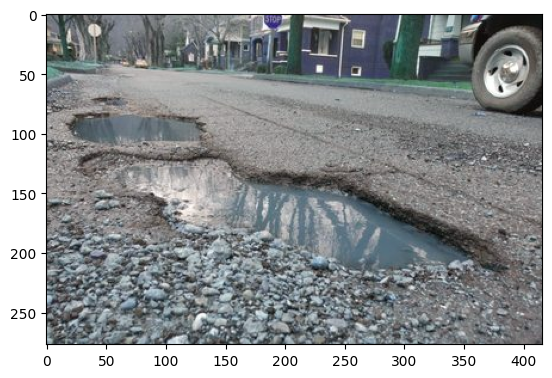

In [21]:
#NOTE: KEEP RUNNING THIS CELL TILL YOU GET A GOOD LOOKING IMAGE

#get test image
test_img_dict = random.choice(dataset_dicts)
img_path = test_img_dict["file_name"]

#preview test image
test_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
plt.imshow(test_img)

In [22]:
#model conversion

image_input = get_image_input(test_img, cfg)

if os.path.exists(vino_model_path):
  ov_model = vino_model_path
else:
  ov_model = convert_detectron2_model(model, image_input)
  ov.save_model(ov_model, vino_model_path)

print(ov_model)

<Model: 'Model4'
inputs[
<ConstOutput: names[args] shape[?,?,?] type: f32>
]
outputs[
<ConstOutput: names[2932, 2935, 2937, 2914, tensor, 2930, 2905, tensor.37] shape[..100,4] type: f32>,
<ConstOutput: names[class_pred] shape[..100] type: i64>,
<ConstOutput: names[] shape[?,1,28,28] type: f32>,
<ConstOutput: names[] shape[..100] type: f32>,
<ConstOutput: names[image_size] shape[2] type: i64>
]>


#### Inference with the Converted Model

In [25]:
device = "AUTO"
core = ov.Core()
compiled_model = core.compile_model(ov_model, device)

In [26]:
start_time = time.time()
results = compiled_model(image_input[0]["image"])
end_time = time.time()

inf_time = end_time - start_time

print(f"Inference Time: {inf_time:.2f} secs")

Inference Time: 11.28 secs


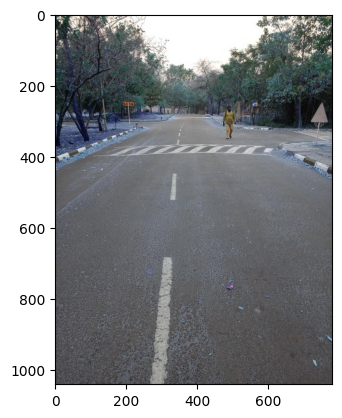

In [27]:
#get test image
test_img_dict = random.choice(dataset_dicts)
img_path = test_img_dict["file_name"]

#preview test image
test_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
plt.imshow(test_img)
image_input = get_image_input(test_img, cfg)
results = compiled_model(image_input[0]["image"])

In [ ]:
# results.__dir__()

#### Helpers for wrapping output in original Detectron2 format to reuse Detectron2 API for postprocessing and visualization

In [28]:
image_input[0].keys()
list(image_input[0].values())[1:]

[1040, 780]

In [29]:
pred = postprocess_detection_result(results, image_input[0]["height"], image_input[0]["width"])

In [30]:
pred._fields.keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])

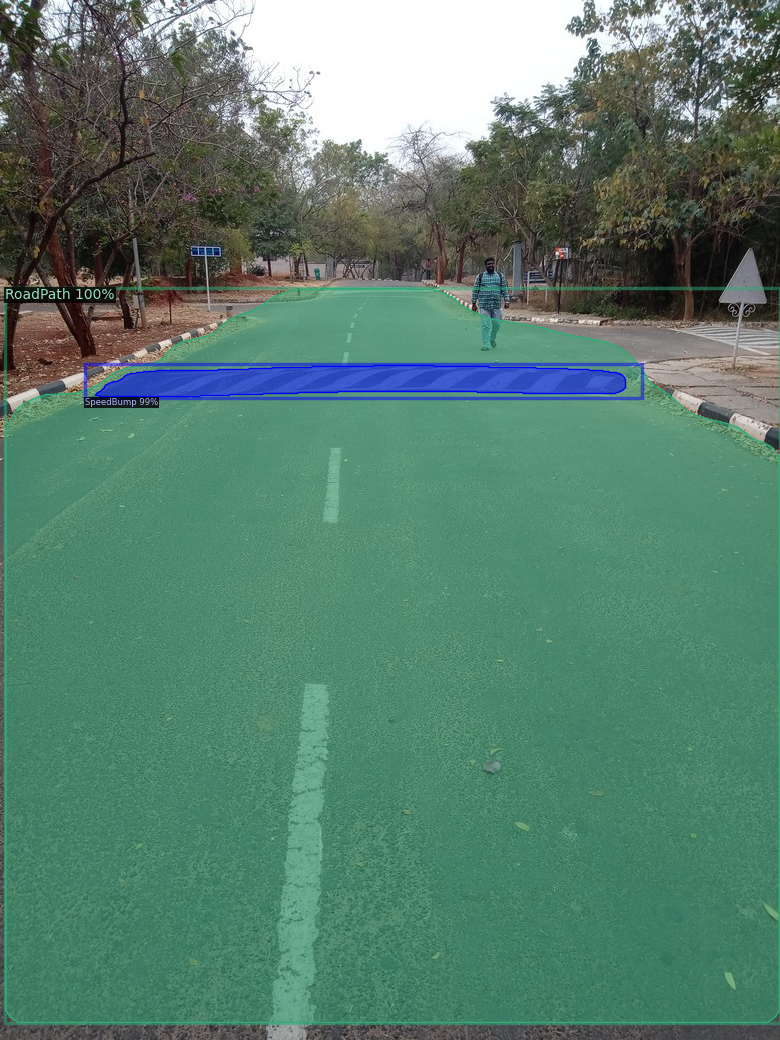

In [31]:
# img_with_res = draw_instance_prediction(test_img, pred, cfg)
img_with_res = draw_instance_prediction(test_img, pred, cfg, metadata)

cv2_imshow(img_with_res.get_image())

In [32]:
# Assuming you have the data stored in a variable called 'pred'
pred_boxes = pred.pred_boxes.tensor

# Extract the bounding box coordinates
pred_boxes = pred_boxes.tolist()
# pred_boxes

In [33]:
pred_classes = pred.pred_classes.tolist()
pred_classes

[1, 2]

In [34]:
id_boxes = {}
for class_id, box in zip(pred_classes, pred_boxes):
  if class_id != 0: continue
#   id_boxes[class_id] = box

# id_boxes

  xmin, ymin, xmax, ymax = box
  # Crop the bounding box region from the image
  cropped_image = test_img[int(ymin):int(ymax), int(xmin):int(xmax)]
  plt.imshow(cropped_image)
  break

In [41]:
h, w, _ = test_img.shape
print(h, w)
orig_img = test_img.copy()

for seg, bbox, class_id in zip(pred.pred_masks, pred_boxes, pred_classes):
  if class_id != 0: continue
  seg = seg.numpy()
  img = overlay(orig_img, seg)
  xmin, ymin, xmax, ymax = [int(box) for box in bbox]

  cropped_image = img[ymin: ymax, xmin:xmax, :]

  break

plt.imshow(cropped_image)

1040 780


NameError: name 'cropped_image' is not defined

1040 780


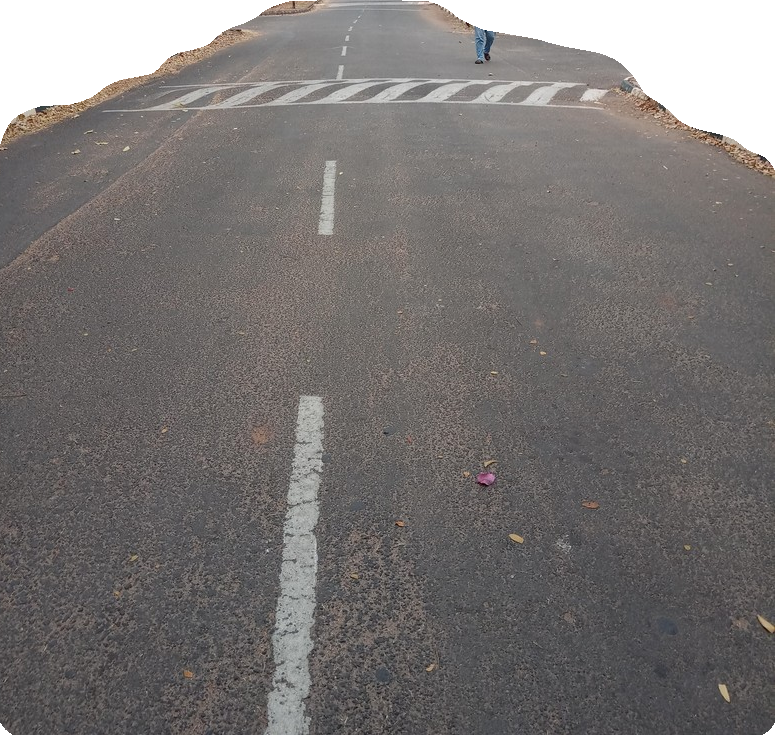

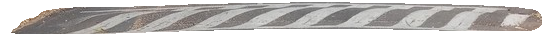

In [42]:
h, w, _ = test_img.shape
print(h, w)
orig_img = test_img.copy()

for seg, bbox in zip(pred.pred_masks, pred_boxes):
  seg = seg.numpy()
  img = overlay(orig_img, seg)
  xmin, ymin, xmax, ymax = [int(box) for box in bbox]

  cropped_image = img[ymin: ymax, xmin:xmax, :]
  cv2_imshow(cropped_image)